# Site-Specific SVM Classification for ENIGMA-OCD

This notebook performs binary classification (OCD vs Control) using an SVM model for each site separately.
The goal is to investigate if the data within each site contains enough signal for classification, helping to verify if low LOSO-CV performance is due to site heterogeneity or lack of signal.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# --- Configuration ---
# Paths (Update these if running locally vs on cluster)
METADATA_PATH = "/pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_QC_final_subject_list.csv"
DATA_DIR_TEMPLATE = "/pscratch/sd/p/pakmasha/enigma_quantum_data/{subject_id}/{subject_id}.npy"

# Model Parameters
TARGET_COL = "OCD"  # Target column in metadata (e.g., 'OCD' or 'Diagnosis')
SITE_COL = "Sample" # Site column in metadata
SUBJECT_ID_COL = "Unique_ID" # Subject ID column

# SVM Parameters
SVM_KERNEL = 'linear' # Basic linear kernel as requested
CV_FOLDS = 5          # Number of folds for within-site CV
MIN_SAMPLES_PER_CLASS = 10 # Minimum samples per class to run analysis for a site

In [3]:
def load_data(metadata_path, data_dir_template, target_col, site_col=SITE_COL):
    """
    Loads metadata and fMRI data, computes Functional Connectivity (FC) matrices.
    Returns: X (features), y (labels), sites (site_ids), subject_ids
    """
    print(f"Loading metadata from {metadata_path}...")
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at {metadata_path}. Please check the path.")
        
    df = pd.read_csv(metadata_path)
    
    # Ensure necessary columns exist
    required_cols = [SUBJECT_ID_COL, site_col, target_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' missing from metadata.")
            
    # Drop rows with missing values in required columns
    df = df.dropna(subset=required_cols)
    
    X_list = []
    y_list = []
    sites_list = []
    ids_list = []
    
    print(f"Found {len(df)} subjects in metadata. Loading fMRI data and computing FC...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        subj_id = row[SUBJECT_ID_COL]
        site = row[site_col]
        
        # Load fMRI
        fmri_path = data_dir_template.format(subject_id=subj_id)
        
        if not os.path.exists(fmri_path):
            # print(f"File not found: {fmri_path}")
            continue
            
        try:
            # Load time series: Shape is expected to be (Time, Regions)
            # Based on code repo, raw file is (time_points, brain_regions)
            ts = np.load(fmri_path)
            
            # Simple validation on shape
            if ts.ndim != 2:
                print(f"Skipping {subj_id}: Unexpected shape {ts.shape}")
                continue
                
            # Compute Functional Connectivity (Pearson correlation)
            # np.corrcoef expects (Variables, Observations) -> (Regions, Time)
            # So transpose the time-series: ts.T
            fc_matrix = np.corrcoef(ts.T)
            
            # Use upper triangle of the correlation matrix as features
            # k=1 to exclude diagonal (which is always 1)
            upper_tri_indices = np.triu_indices_from(fc_matrix, k=1)
            features = fc_matrix[upper_tri_indices]
            
            # Replace NaNs if any (e.g. constant regions)
            if np.isnan(features).any():
                 features = np.nan_to_num(features)
            
            X_list.append(features)
            y_list.append(row[target_col])
            sites_list.append(site)
            ids_list.append(subj_id)
            
        except Exception as e:
            print(f"Error processing {subj_id}: {e}")
            
    return np.array(X_list), np.array(y_list), np.array(sites_list), np.array(ids_list)

# Load the data
# Note: Ensure you have access to the data directories or update the paths above.
try:
    X, y, sites, subject_ids = load_data(METADATA_PATH, DATA_DIR_TEMPLATE, TARGET_COL)
    print(f"Successfully loaded data for {len(y)} subjects.")
    print(f"Feature shape: {X.shape}")
except Exception as e:
    print(f"Failed to load data: {e}")
    X, y, sites, subject_ids = [], [], [], []

Loading metadata from /pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_QC_final_subject_list.csv...
Found 2095 subjects in metadata. Loading fMRI data and computing FC...


100%|██████████| 2095/2095 [00:03<00:00, 594.96it/s] 


Successfully loaded data for 1706 subjects.
Feature shape: (1706, 50403)


In [4]:
# Analyze each site
if len(X) > 0:
    unique_sites = np.unique(sites)
    results = []

    print(f"\n--- Starting Site-Specific SVM Analysis ({len(unique_sites)} sites) ---\n")

    for site in unique_sites:
        # Filter data for this site
        site_mask = (sites == site)
        X_site = X[site_mask]
        y_site = y[site_mask]
        
        # Check class distribution
        classes, counts = np.unique(y_site, return_counts=True)
        class_counts = dict(zip(classes, counts))
        n_samples = len(y_site)
        
        print(f"Site: {site} | Samples: {n_samples} | Distribution: {class_counts}")
        
        # Check if we have enough samples for both classes
        if len(classes) < 2:
            print(f'  -> Skipping: Only one class present.')
            results.append({'Site': site, 'Valid': False, 'Reason': 'Single Class', 'AUC': np.nan, 'Accuracy': np.nan, 'Samples': n_samples})
            continue
            
        if min(counts) < MIN_SAMPLES_PER_CLASS:
            print(f'  -> Skipping: Too few samples per class (Min {MIN_SAMPLES_PER_CLASS}).')
            results.append({'Site': site, 'Valid': False, 'Reason': 'Insufficient Samples', 'AUC': np.nan, 'Accuracy': np.nan, 'Samples': n_samples})
            continue
            
        # Run SVM with Cross-Validation
        # Normalize features (StandardScaler is standard for SVM)
        # Create Pipeline (Scaler + SVM) to prevent data leakage
        clf = make_pipeline(StandardScaler(), SVC(kernel=SVM_KERNEL, probability=True, random_state=42))
        
        # Use Stratified K-Fold
        # Ensure n_splits is not greater than min class count
        n_splits = min(CV_FOLDS, min(counts))
        if n_splits < 2:
             print(f'  -> Skipping: Cannot perform CV (min class count < 2).')
             continue
             
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        try:
            # Calculate metrics using cross_validate to get training scores
            scoring = {'auc': 'roc_auc', 'accuracy': 'accuracy'}
            scores = cross_validate(clf, X_site, y_site, cv=cv, scoring=scoring, return_train_score=True)
            
            mean_test_auc = np.mean(scores['test_auc'])
            mean_train_auc = np.mean(scores['train_auc'])
            mean_test_acc = np.mean(scores['test_accuracy'])
            mean_train_acc = np.mean(scores['train_accuracy'])
            
            print(f"  -> Result: Test AUC = {mean_test_auc:.3f} (Train: {mean_train_auc:.3f}) | Test Acc = {mean_test_acc:.3f} (Train: {mean_train_acc:.3f})")
            
            results.append({
                'Site': site,
                'Valid': True,
                'Reason': 'Analyzed',
                'AUC': mean_test_auc,
                'Train_AUC': mean_train_auc,
                'Accuracy': mean_test_acc,
                'Train_Accuracy': mean_train_acc,
                'Samples': n_samples,
                'Positives': class_counts.get(1, 0),
                'Negatives': class_counts.get(0, 0)
            })
            
        except Exception as e:
            print(f"  -> Error during CV: {e}")
            results.append({'Site': site, 'Valid': False, 'Reason': f"Error: {str(e)}", 'AUC': np.nan, 'Accuracy': np.nan, 'Samples': n_samples})

    results_df = pd.DataFrame(results)
    print("\nAnalysis Complete.")
else:
    print("No data loaded. Please check paths.")


--- Starting Site-Specific SVM Analysis (23 sites) ---

Site: Amsterdam-VUmc | Samples: 57 | Distribution: {np.int64(0): np.int64(28), np.int64(1): np.int64(29)}
  -> Result: Test AUC = 0.411 (Train: 1.000) | Test Acc = 0.461 (Train: 1.000)
Site: Bangalore-NIMHANS | Samples: 358 | Distribution: {np.int64(0): np.int64(189), np.int64(1): np.int64(169)}
  -> Result: Test AUC = 0.733 (Train: 1.000) | Test Acc = 0.676 (Train: 1.000)
Site: Barcelona-HCPB | Samples: 64 | Distribution: {np.int64(0): np.int64(28), np.int64(1): np.int64(36)}
  -> Result: Test AUC = 0.657 (Train: 1.000) | Test Acc = 0.579 (Train: 1.000)
Site: Barcelone-Bellvitge-ANTIGA-1.5T | Samples: 137 | Distribution: {np.int64(0): np.int64(86), np.int64(1): np.int64(51)}
  -> Result: Test AUC = 0.818 (Train: 1.000) | Test Acc = 0.731 (Train: 1.000)
Site: Barcelone-Bellvitge-PROV-1.5T | Samples: 64 | Distribution: {np.int64(0): np.int64(21), np.int64(1): np.int64(43)}
  -> Result: Test AUC = 0.774 (Train: 1.000) | Test Acc = 

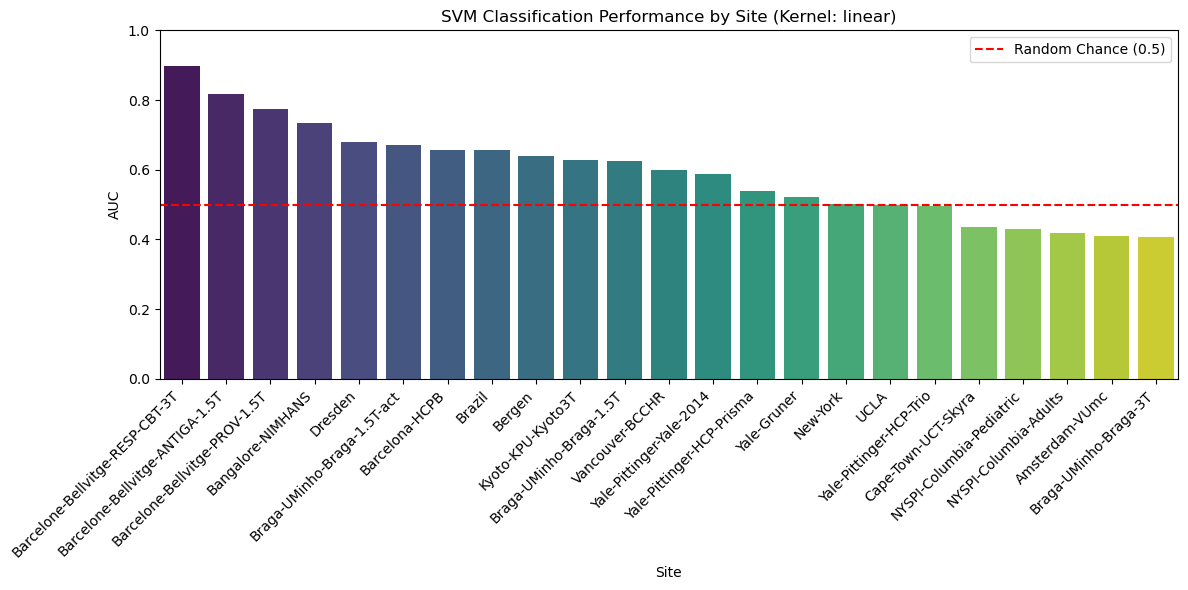


Summary Table:
                               Site  Samples    AUC  Train_AUC  Accuracy  \
5   Barcelone-Bellvitge-RESP-CBT-3T       57  0.898        1.0     0.824   
3   Barcelone-Bellvitge-ANTIGA-1.5T      137  0.818        1.0     0.731   
4     Barcelone-Bellvitge-PROV-1.5T       64  0.774        1.0     0.767   
1                 Bangalore-NIMHANS      358  0.733        1.0     0.676   
12                          Dresden       35  0.680        1.0     0.657   
8       Braga-UMinho-Braga-1.5T-act       96  0.672        1.0     0.666   
2                    Barcelona-HCPB       64  0.657        1.0     0.579   
10                           Brazil       93  0.657        1.0     0.646   
6                            Bergen       53  0.640        1.0     0.569   
13                Kyoto-KPU-Kyoto3T       70  0.628        1.0     0.600   
7           Braga-UMinho-Braga-1.5T       46  0.625        1.0     0.569   
18                  Vancouver-BCCHR       45  0.600        1.0     0.622

In [5]:
# Visualization
if 'results_df' in locals() and not results_df.empty:
    valid_results = results_df[results_df['Valid'] == True].sort_values('AUC', ascending=False)

    if not valid_results.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=valid_results, x='Site', y='AUC', palette='viridis')
        plt.axhline(0.5, color='red', linestyle='--', label='Random Chance (0.5)')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'SVM Classification Performance by Site (Kernel: {SVM_KERNEL})')
        plt.ylim(0, 1.0)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print("\nSummary Table:")
        print(valid_results[['Site', 'Samples', 'AUC', 'Train_AUC', 'Accuracy', 'Train_Accuracy']].round(3))
    else:
        print("No valid sites found for analysis visualization.")
else:
    print("No results to visualize.")